In [44]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler





In [21]:
file_path = 'src\\Dataset\\Liver Patient Dataset (LPD)_train.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')


In [37]:
data.columns = data.columns.str.strip()

In [33]:
nafld_columns = ['Age of the patient', 'Total Bilirubin', 'ALB Albumin', 'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase']
lft_columns = ['Total Bilirubin', 'Direct Bilirubin', 'Alkphos Alkaline Phosphotase', 'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase', 'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio']
albi_columns = ['Total Bilirubin', 'ALB Albumin']

In [22]:

data['Gender of the patient'].fillna(data['Gender of the patient'].mode()[0], inplace=True)
numeric_features = data.select_dtypes(include=[np.number]).columns
categorical_features = ['Gender of the patient']

C:\Users\ssudh\AppData\Local\Temp\ipykernel_7512\4020430053.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender of the patient'].fillna(data['Gender of the patient'].mode()[0], inplace=True)


In [23]:

imputer = SimpleImputer(strategy='mean')
data[numeric_features] = imputer.fit_transform(data[numeric_features])

In [24]:
encoder = OneHotEncoder(drop='first')
gender_encoded = encoder.fit_transform(data[categorical_features]).toarray()


In [25]:
data.head(3)

,Age of the patient,Gender of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result
0,65.0,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1.0
1,62.0,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0
2,62.0,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0


In [26]:
gender_encoded_df = pd.DataFrame(gender_encoded, columns=[f"Gender_{i}" for i in range(gender_encoded.shape[1])])

data = data.drop(columns=categorical_features)
data = pd.concat([data, gender_encoded_df], axis=1)

data.columns = data.columns.astype(str)


In [27]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


In [28]:
def optimal_clusters(data, max_clusters=10):
    distances = pairwise_distances(data, metric='euclidean')
    laplacian = np.diag(distances.sum(axis=1)) - distances
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), np.diff(eigenvalues[:max_clusters + 1]), marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Eigengap')
    plt.title('Eigengap Heuristic')
    plt.show()
    
    eigengap = np.diff(eigenvalues[:max_clusters + 1])
    optimal_k = np.argmax(eigengap) + 1
    return optimal_k


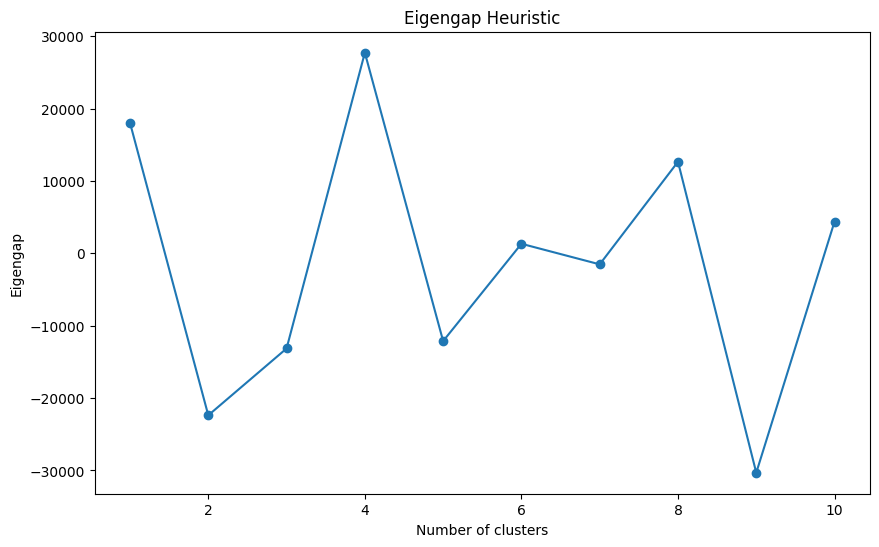

In [29]:
optimal_k = optimal_clusters(data_scaled)

In [53]:
data_nafld = data[nafld_columns]
data_lft = data[lft_columns]
data_albi = data[albi_columns]

spectral = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors', random_state=42)

nafld_clusters = spectral.fit_predict(data_nafld)
lft_clusters = spectral.fit_predict(data_lft)
albi_clusters = spectral.fit_predict(data_albi)




C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [54]:
data['NAFLD_Spectral_Cluster'] = nafld_clusters
data['LFT_Spectral_Cluster'] = lft_clusters
data['ALBI_Spectral_Cluster'] = albi_clusters

In [55]:
X_nafld = data[nafld_columns + ['NAFLD_Spectral_Cluster']]
X_lft = data[lft_columns + ['LFT_Spectral_Cluster']]
X_albi = data[albi_columns + [ 'ALBI_Spectral_Cluster']]
y = data['Result']

In [56]:
X_train_nafld, X_test_nafld, y_train, y_test = train_test_split(X_nafld, y, test_size=0.3, random_state=42)
X_train_lft, X_test_lft, _, _ = train_test_split(X_lft, y, test_size=0.3, random_state=42)
X_train_albi, X_test_albi, _, _ = train_test_split(X_albi, y, test_size=0.3, random_state=42)

In [57]:

X_train_nafld = scaler.fit_transform(X_train_nafld)
X_test_nafld = scaler.transform(X_test_nafld)
X_train_lft = scaler.fit_transform(X_train_lft)
X_test_lft = scaler.transform(X_test_lft)
X_train_albi = scaler.fit_transform(X_train_albi)
X_test_albi = scaler.transform(X_test_albi)


In [47]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': LinearSVC(random_state=42, max_iter=10000),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}


In [48]:
def evaluate_models(X_train, X_test, y_train, y_test, method_name):
    accuracy_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[model_name] = accuracy
        print(f'{model_name} Accuracy for {method_name}: {accuracy}')
        print(classification_report(y_test, y_pred))
    return accuracy_scores

In [58]:
print("NAFLD Method")
nafld_accuracy = evaluate_models(X_train_nafld, X_test_nafld, y_train, y_test, 'NAFLD')

print("\nLFT Method")
lft_accuracy = evaluate_models(X_train_lft, X_test_lft, y_train, y_test, 'LFT')

print("\nALBI Method")
albi_accuracy = evaluate_models(X_train_albi, X_test_albi, y_train, y_test, 'ALBI')

NAFLD Method
Logistic Regression Accuracy for NAFLD: 0.720351867940921
              precision    recall  f1-score   support

         1.0       0.73      0.97      0.83      6627
         2.0       0.51      0.09      0.15      2581

    accuracy                           0.72      9208
   macro avg       0.62      0.53      0.49      9208
weighted avg       0.67      0.72      0.64      9208

Random Forest Accuracy for NAFLD: 0.9937011294526499
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      6627
         2.0       1.00      0.98      0.99      2581

    accuracy                           0.99      9208
   macro avg       0.99      0.99      0.99      9208
weighted avg       0.99      0.99      0.99      9208



C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVC Accuracy for NAFLD: 0.7161164205039097
              precision    recall  f1-score   support

         1.0       0.72      0.99      0.83      6627
         2.0       0.35      0.02      0.03      2581

    accuracy                           0.72      9208
   macro avg       0.54      0.50      0.43      9208
weighted avg       0.62      0.72      0.61      9208

Naive Bayes Accuracy for NAFLD: 0.5169417897480452
              precision    recall  f1-score   support

         1.0       0.95      0.35      0.51      6627
         2.0       0.36      0.95      0.52      2581

    accuracy                           0.52      9208
   macro avg       0.66      0.65      0.52      9208
weighted avg       0.78      0.52      0.51      9208

K-Nearest Neighbors Accuracy for NAFLD: 0.8482841007819287
              precision    recall  f1-score   support

         1.0       0.89      0.90      0.90      6627
         2.0       0.74      0.71      0.72      2581

    accuracy                 

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Accuracy for NAFLD: 0.7662901824500434
              precision    recall  f1-score   support

         1.0       0.80      0.89      0.85      6627
         2.0       0.62      0.44      0.51      2581

    accuracy                           0.77      9208
   macro avg       0.71      0.67      0.68      9208
weighted avg       0.75      0.77      0.75      9208

Decision Tree Accuracy for NAFLD: 0.9903344917463076
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      6627
         2.0       0.98      0.98      0.98      2581

    accuracy                           0.99      9208
   macro avg       0.99      0.99      0.99      9208
weighted avg       0.99      0.99      0.99      9208


LFT Method
Logistic Regression Accuracy for LFT: 0.7185056472632494
              precision    recall  f1-score   support

         1.0       0.75      0.92      0.83      6627
         2.0       0.49      0.19      0.28      2581

    ac

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVC Accuracy for LFT: 0.7277367506516073
              precision    recall  f1-score   support

         1.0       0.73      0.97      0.84      6627
         2.0       0.59      0.09      0.16      2581

    accuracy                           0.73      9208
   macro avg       0.66      0.53      0.50      9208
weighted avg       0.69      0.73      0.65      9208

Naive Bayes Accuracy for LFT: 0.5610338835794961
              precision    recall  f1-score   support

         1.0       0.96      0.41      0.57      6627
         2.0       0.39      0.96      0.55      2581

    accuracy                           0.56      9208
   macro avg       0.67      0.68      0.56      9208
weighted avg       0.80      0.56      0.57      9208

K-Nearest Neighbors Accuracy for LFT: 0.9833840139009556
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      6627
         2.0       0.97      0.97      0.97      2581

    accuracy                       

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Accuracy for LFT: 0.8937880104257168
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93      6627
         2.0       0.82      0.80      0.81      2581

    accuracy                           0.89      9208
   macro avg       0.87      0.86      0.87      9208
weighted avg       0.89      0.89      0.89      9208

Decision Tree Accuracy for LFT: 0.9915291051259774
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      6627
         2.0       0.99      0.98      0.98      2581

    accuracy                           0.99      9208
   macro avg       0.99      0.99      0.99      9208
weighted avg       0.99      0.99      0.99      9208


ALBI Method
Logistic Regression Accuracy for ALBI: 0.7167680278019114
              precision    recall  f1-score   support

         1.0       0.72      1.00      0.84      6627
         2.0       0.00      0.00      0.00      2581

    accu

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


K-Nearest Neighbors Accuracy for ALBI: 0.8504561251086012
              precision    recall  f1-score   support

         1.0       0.90      0.90      0.90      6627
         2.0       0.73      0.73      0.73      2581

    accuracy                           0.85      9208
   macro avg       0.81      0.82      0.81      9208
weighted avg       0.85      0.85      0.85      9208

Neural Network Accuracy for ALBI: 0.7389226759339704
              precision    recall  f1-score   support

         1.0       0.77      0.90      0.83      6627
         2.0       0.56      0.33      0.41      2581

    accuracy                           0.74      9208
   macro avg       0.67      0.61      0.62      9208
weighted avg       0.71      0.74      0.71      9208

Decision Tree Accuracy for ALBI: 0.8693527367506516
              precision    recall  f1-score   support

         1.0       0.90      0.91      0.91      6627
         2.0       0.77      0.75      0.76      2581

    accuracy       

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [59]:
def compare_accuracies(nafld_accuracy, lft_accuracy, albi_accuracy):
    print("\nOverall Accuracy Comparison:")
    for model_name in models.keys():
        print(f"{model_name}:")
        print(f"  NAFLD Accuracy: {nafld_accuracy[model_name]}")
        print(f"  LFT Accuracy: {lft_accuracy[model_name]}")
        print(f"  ALBI Accuracy: {albi_accuracy[model_name]}")
        print()


In [61]:
compare_accuracies(nafld_accuracy, lft_accuracy, albi_accuracy)


Overall Accuracy Comparison:
Logistic Regression:
  NAFLD Accuracy: 0.720351867940921
  LFT Accuracy: 0.7185056472632494
  ALBI Accuracy: 0.7167680278019114

Random Forest:
  NAFLD Accuracy: 0.9937011294526499
  LFT Accuracy: 0.996524761077324
  ALBI Accuracy: 0.8702215464813206

SVC:
  NAFLD Accuracy: 0.7161164205039097
  LFT Accuracy: 0.7277367506516073
  ALBI Accuracy: 0.7183970460469157

Naive Bayes:
  NAFLD Accuracy: 0.5169417897480452
  LFT Accuracy: 0.5610338835794961
  ALBI Accuracy: 0.5165073848827106

K-Nearest Neighbors:
  NAFLD Accuracy: 0.8482841007819287
  LFT Accuracy: 0.9833840139009556
  ALBI Accuracy: 0.8504561251086012

Neural Network:
  NAFLD Accuracy: 0.7662901824500434
  LFT Accuracy: 0.8937880104257168
  ALBI Accuracy: 0.7389226759339704

Decision Tree:
  NAFLD Accuracy: 0.9903344917463076
  LFT Accuracy: 0.9915291051259774
  ALBI Accuracy: 0.8693527367506516

